In [15]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import sys
from scipy.signal import welch

%matplotlib inline

# Probe Processing @ (1.0, 0.5, 0.5) #
### Data acquisition and organization ###

In [17]:
# Choose data set to process
fine_resolution = False
fname = ''
if fine_resolution:
    fname = './postProcessing/center_probe/290.5/U'
else:
    fname = './postProcessing_60/center_probe/50/U'

# Read data to DataFrame
u = pd.read_csv(fname,delim_whitespace=True,comment='#',header=None,index_col=0)
# Create ux, uy, and uz MultiIndex columns for each probe point
cols = pd.MultiIndex.from_tuples([(x,y) for x in range(int(u.shape[1]/3)) for y in ['ux','uy','uz']])

# Apply MultiIndex columns to DataFrame
u.columns = cols
# Modify DataFrame column names
u.index.name = 'Time'
u.columns.names = ['Probes','Component']

# Create full turbulence variable and fluctuating part variable
ueff = u
up = ueff-ueff.mean()

# Gather data from file header
uheader = pd.read_csv(fname,
                      delim_whitespace=True,
                      nrows=int(u.shape[1]/3),
                      names=[0,1,2,'x','y','z'],
                      usecols=[2,'x','y','z'],
                      index_col=0)
uheader.index.name=u.columns.names[0]

### Data processing ###

In [18]:
# Initialize base variables
dt = np.mean(np.diff(u.index))
fs = 1/dt
uStar = 0.41*10/np.log(1/0.00003)
nfft=512
# Estimate power spectral density using Welch's method
# Default parameters not explicitly used:
    # window='hanning'
    # noverlap=None
    # nfft=None
    # detrend='constant'
    # return_onesided=True
    # scaling='density'
    # axis=-1
# Returns 
    # f: array of sample frequencies
    # Pxx: power spectral density or power spectrum of x
n, Su = welch(up[0], fs, axis=0, nperseg=nfft)
# Convert power spectral density into DataFrame indexed by sample frequencies
Su = pd.DataFrame(Su, columns=up[0].columns, index=n)
# Create DataFrame from function applied to all power spectral densities
ndSu = Su.apply(lambda x: x*n/uStar**2)
# Apply function to power spectral density DataFrame indexes and apply to new DataFrame
ndSu.index = n*uheader.z[0]/u[0, 'ux'].mean()

### Plotting and baseline curves ###

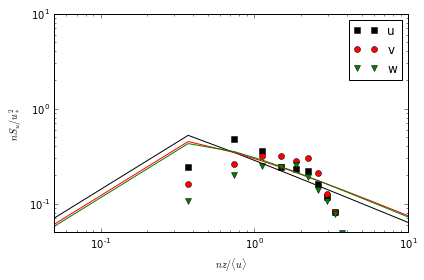

In [19]:
f = ndSu.index.values
# Baseline curves
ndSu['Kaimal u'] = 200.*f/(1+50.*f)**(5./3.)
ndSu['Kaimal v'] = 15.*f/(1+9.5*f)**(5./3.)
ndSu['Kaimal w'] = 3.36*f/(1+10.*f**(5./3.))
# Plot configuration
styles = ['ks','ro','gv','k','r','g']
ax = ndSu.plot(loglog=True,style=styles)
ax.set_xlabel('$nz/\\langle u\\rangle$')
ax.set_ylabel('$nS_u/u_*^2$')
ax.legend(['u','v','w'], loc='best')
# Set axis limits
ax.set_xlim(0.05,10)
ax.set_ylim(0.05, 10)
fig=plt.gcf()
fig.tight_layout()
if fine_resolution:
    fig.savefig('fine_spectrum.png')
else:
    fig.savefig('coarse_spectrum.png')
    
plt.show()

In [10]:
#DEBUG
print("uheader.z[0] = {}".format(uheader.z[0]))
print("u mean = {}".format(u[0, 'ux'].mean()))

uheader.z[0] = 0.5
u mean = 10.498538718548385
